In [2]:
import pandas as pd
import numpy as np
import os
from gensim.models import Word2Vec
from tqdm.notebook import tqdm
from gensim.models import FastText
from gensim.models import KeyedVectors
import numpy as np
from gensim.models import FastText, KeyedVectors
import itertools
from tqdm import tqdm
import random

def find_analogies(model, n_pairs=100, similarity_threshold=0.5, 
                  max_vocab=100, n_candidates=200):
    """
    Automatically discover word analogies in an embedding model.
    
    Args:
        model: A gensim word embedding model (FastText, Word2Vec, or KeyedVectors)
        n_pairs: Number of analogy pairs to find
        similarity_threshold: Minimum similarity for an analogy to be valid
        max_vocab: Only use the top N most frequent words for efficiency
        n_candidates: Number of candidate pairs to evaluate for each source pair
        
    Returns:
        List of tuples representing analogies (a, b, c, d) where a:b :: c:d
    """
    # Extract word vectors
    if hasattr(model, 'wv'):
        wv = model.wv
    else:
        wv = model  # Model is already KeyedVectors
        
    # Get most common words (vocabulary is typically sorted by frequency)
    vocab = wv.index_to_key[:max_vocab]
    
    # Track discovered analogies
    analogies = []
    
    print(f"Searching for analogies among the top {max_vocab} words...")
    
    # Select random seed pairs from common vocabulary
    # We'll look for pairs with reasonable similarity to start
    seed_pairs = []
    
    for _ in tqdm(range(n_candidates * 2), desc="Finding seed pairs"):
        # Select random words
        word1 = random.choice(vocab)
        
        # Find similar words to create a potential relationship
        similar_words = [w for w, _ in wv.most_similar(word1, topn=30)]
        if not similar_words:
            continue
            
        word2 = random.choice(similar_words)
        
        # Check that words aren't too similar or too different
        sim = wv.similarity(word1, word2)
        if 0.3 < sim < 0.8:  # Reasonable similarity range
            seed_pairs.append((word1, word2))
            
    # Filter to the requested number of candidate pairs
    seed_pairs = seed_pairs[:n_candidates]
    
    # For each seed pair, try to find analogies
    for pair1_idx, (a, b) in enumerate(tqdm(seed_pairs, desc="Evaluating analogies")):
        # Calculate relationship vector
        relation_vector = wv[b] - wv[a]
        
        # Compare with other pairs
        for pair2_idx in range(pair1_idx + 1, len(seed_pairs)):
            c, d = seed_pairs[pair2_idx]
            
            # Skip if words overlap
            if a == c or a == d or b == c or b == d:
                continue
                
            # Calculate second relationship vector
            relation_vector2 = wv[d] - wv[c]
            
            # Calculate cosine similarity between relationship vectors
            relation_similarity = np.dot(relation_vector, relation_vector2) / (
                np.linalg.norm(relation_vector) * np.linalg.norm(relation_vector2)
            )
            
            # If relationship vectors are similar, we found an analogy
            if relation_similarity > similarity_threshold:
                analogies.append((a, b, c, d, relation_similarity))
                
                # Check the classic way: a is to b as c is to d
                # This means: b - a + c ≈ d
                predicted_d = wv.most_similar(
                    positive=[b, c], 
                    negative=[a], 
                    topn=5
                )
                
                # Display prediction results
                print(f"\nFound analogy: {a} : {b} :: {c} : {d} (similarity: {relation_similarity:.3f})")
                print(f"When computing {b} - {a} + {c}, the closest words are:")
                for pred_word, sim in predicted_d:
                    check = "✓" if pred_word == d else " "
                    print(f"  {check} {pred_word}: {sim:.3f}")
                
                # Stop if we found enough analogies
                if len(analogies) >= n_pairs:
                    break
        
        if len(analogies) >= n_pairs:
            break
    
    # Sort by similarity
    analogies.sort(key=lambda x: x[4], reverse=True)
    
    return analogies

In [3]:
paths = [os.path.join("Trained_embeddings",path) for path in os.listdir("Trained_embeddings/") if not path.startswith(".") and path.endswith(".model")]
paths[0][31]

'8'

In [4]:
paths[:20]

['Trained_embeddings/fast_tags_0.8.model',
 'Trained_embeddings/word2vec_words_0.8.model',
 'Trained_embeddings/word2vec_tags_0.6.model',
 'Trained_embeddings/fast_tags_0.2.model',
 'Trained_embeddings/word2vec_tags_0.9.model',
 'Trained_embeddings/fast_words_0.9.model',
 'Trained_embeddings/word2vec_words_0.5.model',
 'Trained_embeddings/word2vec_words_1.0.model',
 'Trained_embeddings/fast_tags_0.3.model',
 'Trained_embeddings/word2vec_words_0.6.model',
 'Trained_embeddings/fast_tags_1.0.model',
 'Trained_embeddings/fast_tags_0.9.model',
 'Trained_embeddings/word2vec_words_0.7.model',
 'Trained_embeddings/fast_tags_0.4.model',
 'Trained_embeddings/word2vec_tags_1.0.model',
 'Trained_embeddings/fast_words_0.4.model',
 'Trained_embeddings/fast_words_0.7.model',
 'Trained_embeddings/word2vec_tags_0.2.model',
 'Trained_embeddings/word2vec_words_0.2.model',
 'Trained_embeddings/word2vec_tags_0.7.model']

In [5]:
trained_embeddings = {}
for path in paths[:20]:
    trained_embeddings[path.split("/")[-1].replace(".model","").replace("0.","")] = KeyedVectors.load(path)

In [6]:
trained_embeddings

{'fast_tags_8': <gensim.models.fasttext.FastText at 0x7fc5b624a470>,
 'word2vec_words_8': <gensim.models.word2vec.Word2Vec at 0x7fc5b6249960>,
 'word2vec_tags_6': <gensim.models.word2vec.Word2Vec at 0x7fc5b6249cc0>,
 'fast_tags_2': <gensim.models.fasttext.FastText at 0x7fc5b62480d0>,
 'word2vec_tags_9': <gensim.models.word2vec.Word2Vec at 0x7fc5b624aa40>,
 'fast_words_9': <gensim.models.fasttext.FastText at 0x7fc5b6249ba0>,
 'word2vec_words_5': <gensim.models.word2vec.Word2Vec at 0x7fc5b62485b0>,
 'word2vec_words_1.0': <gensim.models.word2vec.Word2Vec at 0x7fc5b624a980>,
 'fast_tags_3': <gensim.models.fasttext.FastText at 0x7fc5b624a050>,
 'word2vec_words_6': <gensim.models.word2vec.Word2Vec at 0x7fc5b624a5f0>,
 'fast_tags_1.0': <gensim.models.fasttext.FastText at 0x7fc5b62484c0>,
 'fast_tags_9': <gensim.models.fasttext.FastText at 0x7fc5b624a0e0>,
 'word2vec_words_7': <gensim.models.word2vec.Word2Vec at 0x7fc5b624a9b0>,
 'fast_tags_4': <gensim.models.fasttext.FastText at 0x7fc5b624a38

In [7]:
for k in trained_embeddings:
    print(f"========== k = {k} ===========")
    print(trained_embeddings[k].wv.most_similar("teen", topn=10))

========== k = fast_tags_8 ===========
[('college', 0.7028343081474304), ('teenagers', 0.6907430291175842), ('student', 0.6755899786949158), ('teenage', 0.6561225056648254), ('schoolgirl', 0.6446532607078552), ('teenager', 0.6316220760345459), ('first_time', 0.611845076084137), ('cute', 0.6064928770065308), ('tight', 0.586141049861908), ('cute_girl', 0.5765373706817627)]
========== k = word2vec_words_8 ===========
[('young', 0.6057095527648926), ('cute', 0.5711055397987366), ('college', 0.5414875149726868), ('teenagers', 0.5371202826499939), ('schoolgirl', 0.5130693316459656), ('student', 0.5040149092674255), ('year', 0.4813455045223236), ('teenage', 0.4802781045436859), ('petite', 0.4476187825202942), ('stepdaughter', 0.44746363162994385)]
========== k = word2vec_tags_6 ===========
[('cute', 0.9183071851730347), ('first_time', 0.866838276386261), ('college', 0.8632088899612427), ('tight', 0.8489585518836975), ('schoolgirl', 0.831831157207489), ('student', 0.8283110857009888), ('hot_gi

In [8]:
for k in trained_embeddings:
    print(f"========== k = {k} ===========")
    print(trained_embeddings[k].wv.most_similar("black", topn=10))

========== k = fast_tags_8 ===========
[('big_black_dick', 0.8433091640472412), ('black_girl', 0.8403941988945007), ('big_black_cock', 0.7994299530982971), ('backshots', 0.7127934694290161), ('monster_cock', 0.6735584735870361), ('ebony', 0.6630610227584839), ('bbc', 0.6601160764694214), ('huge_dick', 0.6369391083717346), ('huge_cock', 0.6112397313117981), ('big_ass_ebony', 0.6059178709983826)]
========== k = word2vec_words_8 ===========
[('ebony', 0.5973371267318726), ('backshots', 0.5768945813179016), ('bbc', 0.5665032267570496), ('monster', 0.5448576807975769), ('white', 0.5364041328430176), ('interracial', 0.48220372200012207), ('big', 0.4804409146308899), ('latino', 0.4663901627063751), ('brazilian', 0.4302353858947754), ('cock', 0.42305341362953186)]
========== k = word2vec_tags_6 ===========
[('backshots', 0.9386986494064331), ('ebony', 0.9300516843795776), ('big_black_dick', 0.8899369239807129), ('bbc', 0.8695630431175232), ('ass', 0.8605943322181702), ('big_ass_ebony', 0.85244

In [9]:
for k in trained_embeddings:
    print(f"========== k = {k} ===========")
    print(trained_embeddings[k].wv.most_similar("romantic", topn=20))

========== k = fast_tags_8 ===========
[('romantic_sex', 0.7915974855422974), ('kissing', 0.6797012090682983), ('erotic', 0.6702450513839722), ('sensual', 0.6303775310516357), ('girlfriend', 0.6279378533363342), ('girl_on_girl', 0.6193280816078186), ('czech', 0.6131433844566345), ('日本人', 0.5569289922714233), ('girl', 0.5566599369049072), ('real_couple', 0.5524411797523499), ('cunnilingus', 0.550289511680603), ('couple', 0.5452414155006409), ('face_sitting', 0.5397018790245056), ('fingering', 0.5322948694229126), ('french', 0.52560955286026), ('boobs', 0.5159562826156616), ('smoking', 0.5156319737434387), ('pussy_licking', 0.5154134631156921), ('素人', 0.5070853233337402), ('brunette', 0.5000907182693481)]
========== k = word2vec_words_8 ===========
[('real', 0.5465722680091858), ('kissing', 0.48067209124565125), ('couple', 0.47581613063812256), ('czech', 0.4700539708137512), ('日本人', 0.45077764987945557), ('erotic', 0.44730788469314575), ('french', 0.4252835512161255), ('sensual', 0.42169

In [10]:
for k in trained_embeddings:
    print(f"========== k = {k} ===========")
    print(trained_embeddings[k].wv.most_similar("czech", topn=10))

========== k = fast_tags_8 ===========
[('european', 0.8068253993988037), ('girl_on_girl', 0.7452360987663269), ('german', 0.7377235293388367), ('kissing', 0.7005307674407959), ('shaved', 0.7004444003105164), ('brunette', 0.6934117674827576), ('french', 0.6605340242385864), ('lesbians', 0.6409574747085571), ('fake_tits', 0.6388165354728699), ('tits', 0.6355224251747131)]
========== k = word2vec_words_8 ===========
[('european', 0.6701477766036987), ('lesbians', 0.6314886212348938), ('kissing', 0.6139113903045654), ('brunette', 0.5888570547103882), ('blonde', 0.571196436882019), ('smoking', 0.5429333448410034), ('high', 0.5211723446846008), ('german', 0.5209746360778809), ('lingerie', 0.5023838877677917), ('fake', 0.49890077114105225)]
========== k = word2vec_tags_6 ===========
[('german', 0.9734222888946533), ('shaved', 0.9616031050682068), ('jock', 0.9451949000358582), ('blow_job', 0.9323057532310486), ('anal_fingering', 0.9272873997688293), ('hairy', 0.9264971613883972), ('pee', 0.92

KeyError: "Key 'czech' not present in vocabulary"

In [11]:
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.manifold import TSNE
from collections import Counter
import re

def plot_word_map(model, num_words=100, perplexity=30,title=None, **kwargs):
    """
    Generates a 2D word map from a Gensim model using t-SNE for dimensionality reduction.
    
    Parameters:
    -----------
    model : gensim model
        A Gensim word embedding model (Word2Vec, FastText, etc.)
    num_words : int, default=100
        Number of most frequent words to include in the visualization
    perplexity : int, default=30
        Perplexity parameter for t-SNE (typically 5-50)
    **kwargs : dict
        Additional keyword arguments for t-SNE
        
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        The Plotly figure object for further customization if needed
    """
    # Extract word vectors from model
    if hasattr(model, 'wv'):
        wv = model.wv
    else:
        wv = model  # Model is already word vectors
    
    # Get the most common words
    words = wv.index_to_key[:num_words]
    
    # Extract vectors for these words
    vectors = np.array([wv[word] for word in words])
    
    # Apply t-SNE to reduce to 2D
    tsne_params = {
        'n_components': 2,
        'random_state': 42,
        'perplexity': perplexity,
        'n_iter': 1000,
        'init': 'pca'
    }
    # Update with any user-provided kwargs
    tsne_params.update(kwargs)
    
    # Check if perplexity is too high for the number of words
    if tsne_params['perplexity'] >= len(words):
        tsne_params['perplexity'] = max(5, len(words) // 2 - 1)
        print(f"Adjusted perplexity to {tsne_params['perplexity']} due to small number of words")
    
    print(f"Applying t-SNE with perplexity={tsne_params['perplexity']}...")
    tsne = TSNE(**tsne_params)
    vectors_2d = tsne.fit_transform(vectors)
    
    # Create a DataFrame for plotting
    df_plot = pd.DataFrame(vectors_2d, columns=["X", "Y"])
    df_plot["Word"] = words
    
    # If the model has word frequencies, include them
    if hasattr(wv, 'get_vecattr') and 'count' in wv.expandos:
        df_plot["Frequency"] = [wv.get_vecattr(word, 'count') for word in words]
    elif hasattr(model, 'corpus_total_words') and hasattr(model, 'wv'):
        # Estimate frequencies from vocabulary ranks
        frequencies = []
        for i, word in enumerate(words):
            # Use Zipf's law to estimate frequency: rank ~ 1/frequency
            # Higher-ranked words (lower index) have higher frequency
            zipf_estimated_freq = model.corpus_total_words / (i + 1)
            frequencies.append(zipf_estimated_freq)
        df_plot["Frequency"] = frequencies
    else:
        # No frequency information available
        df_plot["Frequency"] = 1
    
    # Create the plot
    hover_data = {"Frequency": True, "X": False, "Y": False}
    
    if "Frequency" in df_plot.columns:
        # Scale marker sizes based on frequency
        fig = px.scatter(
            df_plot, 
            x="X", 
            y="Y", 
            text="Word", 
            size="Frequency",
            size_max=30,
            title=title if title else "",
            hover_data=hover_data
        )
    else:
        fig = px.scatter(
            df_plot, 
            x="X", 
            y="Y", 
            text="Word", 
            title="Word Embedding Map (t-SNE projection)",
            hover_data=hover_data
        )
    
    # Improve text visibility
    fig.update_traces(textposition="top center", marker=dict(opacity=0.7))
    
    # Improve layout
    fig.update_layout(
        height=800,
        width=1000,
        xaxis_title="t-SNE dimension 1",
        yaxis_title="t-SNE dimension 2"
    )
    
    return fig


def plot_word_clusters(model, num_words=100, perplexity=30, n_clusters=5):
    """
    Generates a word map with automatic clustering to identify semantic groups.
    
    Parameters:
    -----------
    model : gensim model
        A Gensim word embedding model
    num_words : int, default=100
        Number of words to include
    perplexity : int, default=30
        Perplexity parameter for t-SNE
    n_clusters : int, default=5
        Number of clusters to identify
        
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        The Plotly figure with colored clusters
    """
    from sklearn.cluster import KMeans
    
    # Extract word vectors
    if hasattr(model, 'wv'):
        wv = model.wv
    else:
        wv = model
        
    words = wv.index_to_key[:num_words]
    vectors = np.array([wv[word] for word in words])
    
    # Apply clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(vectors)
    
    # Apply t-SNE
    tsne_params = {
        'n_components': 2,
        'random_state': 42,
        'perplexity': min(perplexity, len(words) // 2 - 1),
        'n_iter': 1000
    }
    
    tsne = TSNE(**tsne_params)
    vectors_2d = tsne.fit_transform(vectors)
    
    # Create DataFrame for plotting
    df_plot = pd.DataFrame(vectors_2d, columns=["X", "Y"])
    df_plot["Word"] = words
    df_plot["Cluster"] = clusters
    
    # Create plot with cluster colors
    fig = px.scatter(
        df_plot, 
        x="X", 
        y="Y", 
        text="Word", 
        color="Cluster",
        title="Word Embedding Clusters",
        color_discrete_sequence=px.colors.qualitative.Bold
    )
    
    fig.update_traces(textposition="top center", marker=dict(size=10, opacity=0.7))
    fig.update_layout(height=800, width=1000)
    
    return fig


def plot_semantic_neighborhood(model, center_word, num_neighbors=30, perplexity=15):
    """
    Plots the semantic neighborhood around a specific word.
    
    Parameters:
    -----------
    model : gensim model
        A Gensim word embedding model
    center_word : str
        The word to explore the neighborhood of
    num_neighbors : int, default=30
        Number of similar words to include
    perplexity : int, default=15
        Perplexity parameter for t-SNE
        
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        The Plotly figure showing the word's neighborhood
    """
    # Extract word vectors
    if hasattr(model, 'wv'):
        wv = model.wv
    else:
        wv = model
    
    # Check if the word is in vocabulary
    if center_word not in wv:
        raise ValueError(f"'{center_word}' is not in the model's vocabulary")
    
    # Find similar words
    similar_words = [word for word, _ in wv.most_similar(center_word, topn=num_neighbors)]
    words = [center_word] + similar_words
    
    # Get vectors for these words
    vectors = np.array([wv[word] for word in words])
    
    # Apply t-SNE
    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=min(perplexity, len(words) // 2 - 1),
        n_iter=1000
    )
    vectors_2d = tsne.fit_transform(vectors)
    
    # Create DataFrame for plotting
    df_plot = pd.DataFrame(vectors_2d, columns=["X", "Y"])
    df_plot["Word"] = words
    df_plot["Type"] = ["Center" if word == center_word else "Neighbor" for word in words]
    
    # Calculate similarities to center word
    df_plot["Similarity"] = [1.0] + [wv.similarity(center_word, word) for word in similar_words]
    
    # Create plot
    fig = px.scatter(
        df_plot, 
        x="X", 
        y="Y", 
        text="Word", 
        color="Type",
        size="Similarity",
        size_max=20,
        title=f"Semantic Neighborhood of '{center_word}'",
        color_discrete_map={"Center": "red", "Neighbor": "blue"},
        hover_data={"Similarity": ":.3f", "X": False, "Y": False}
    )
    
    fig.update_traces(textposition="top center")
    fig.update_layout(height=700, width=900)
    
    return fig


Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


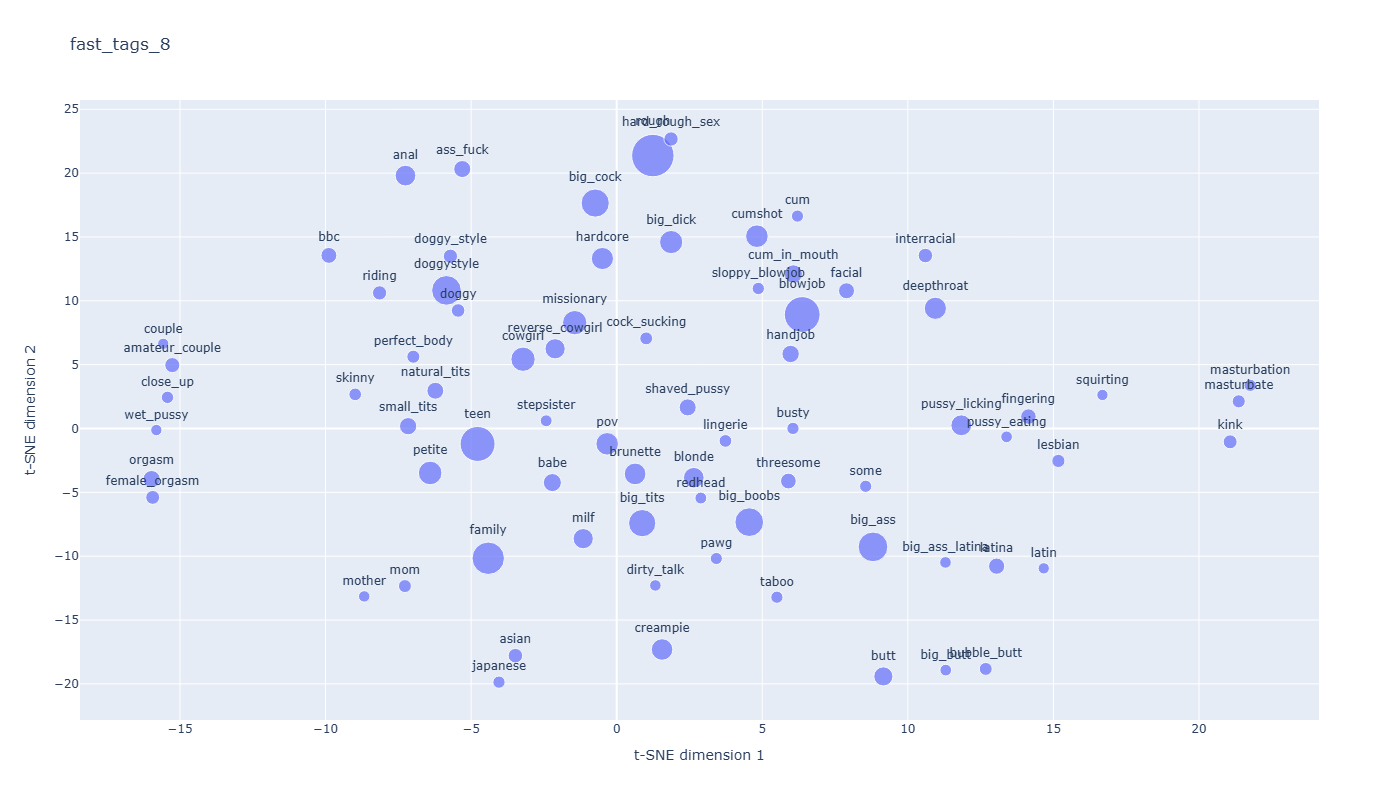

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



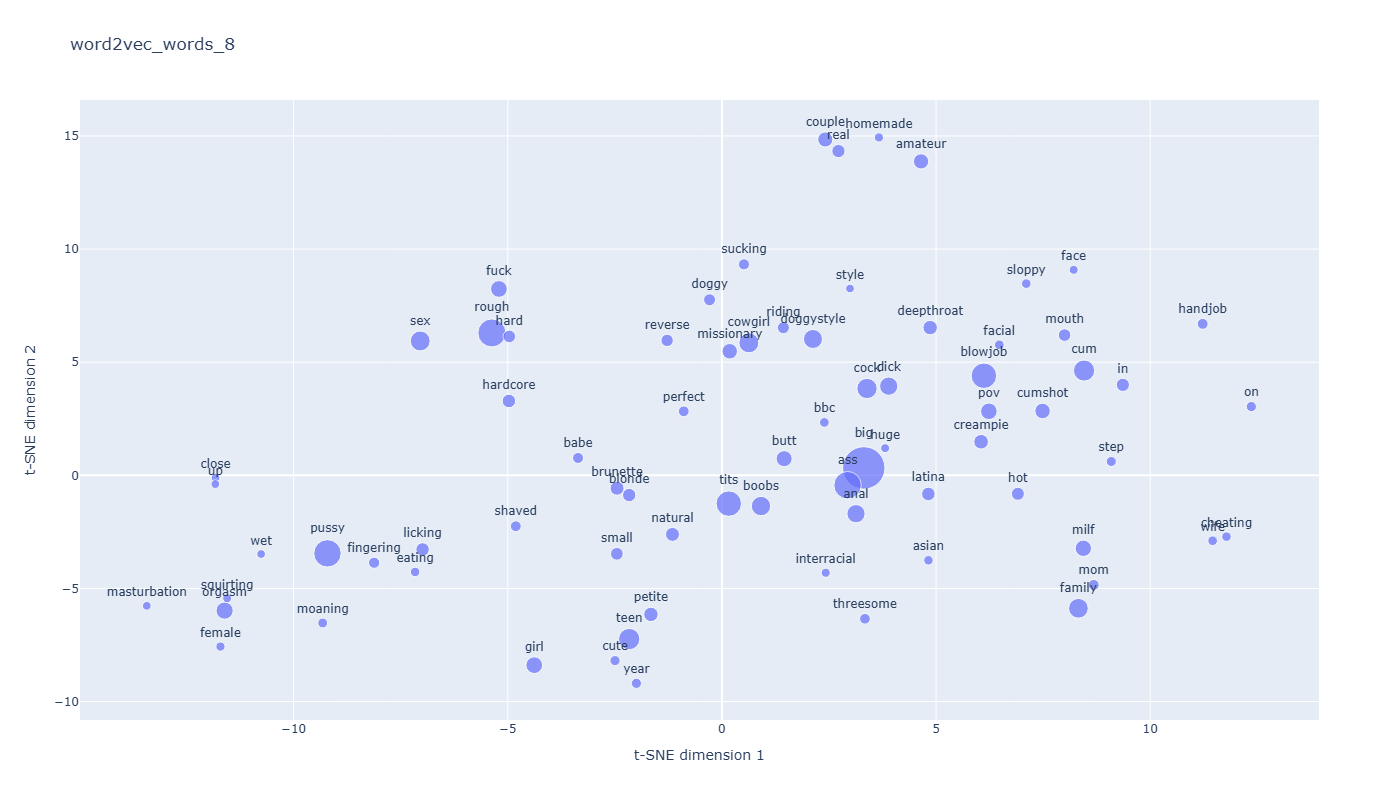

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



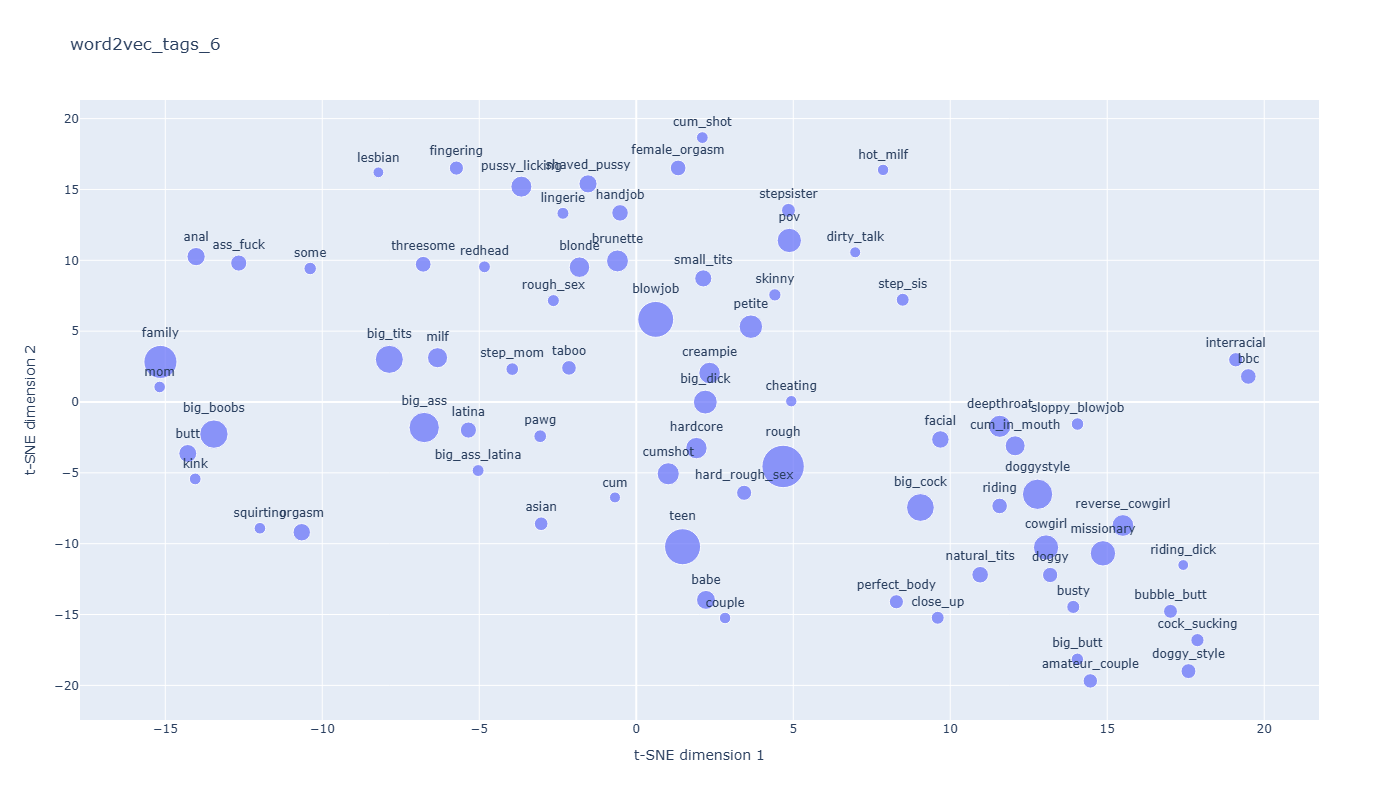

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



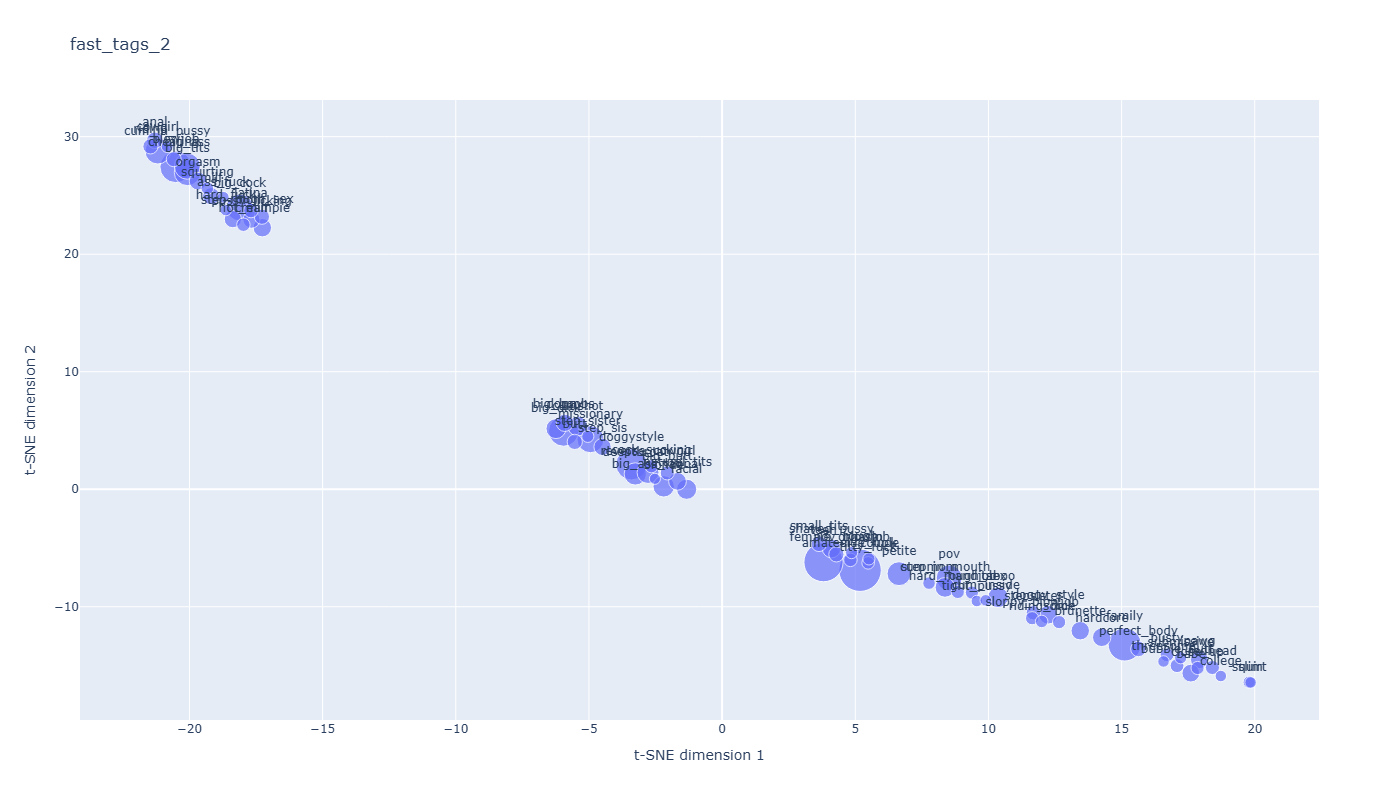

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



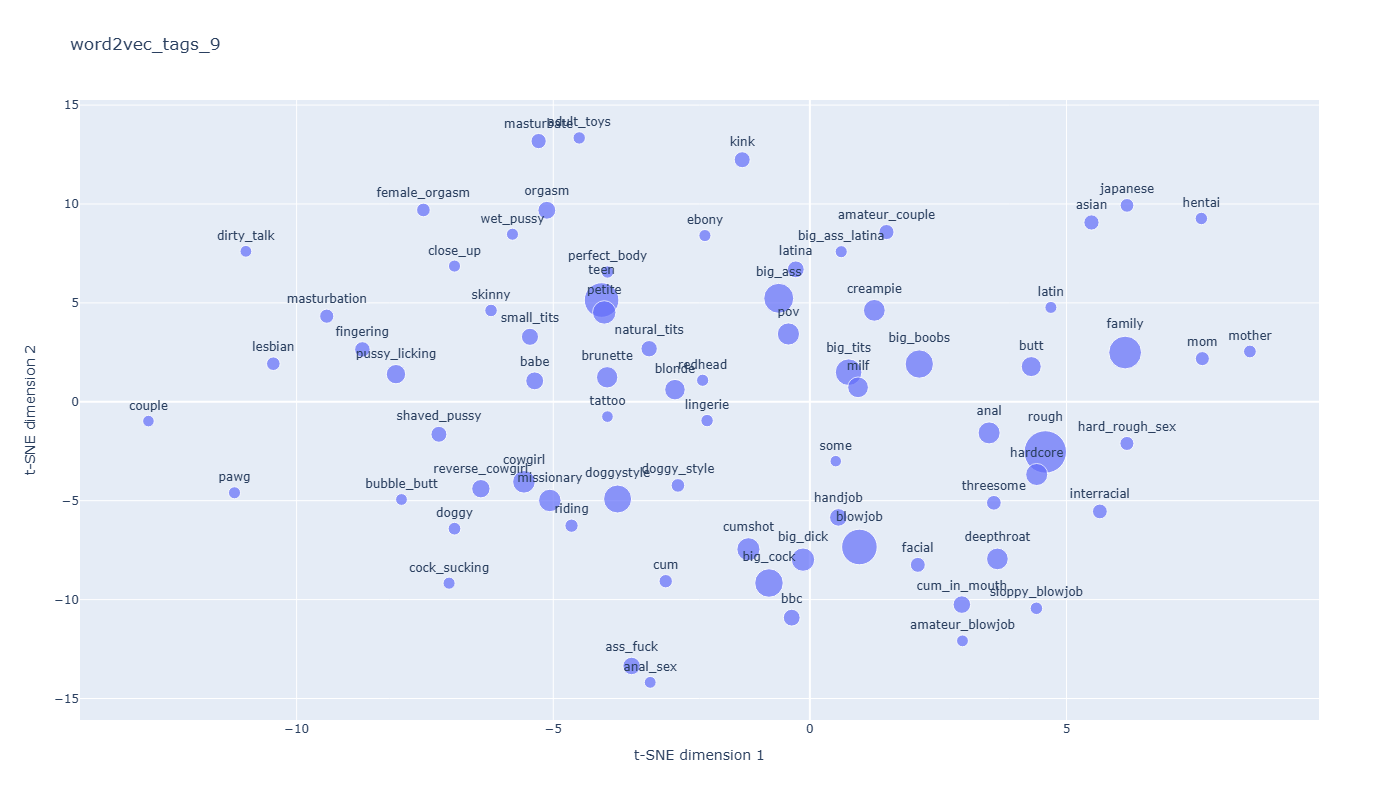

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



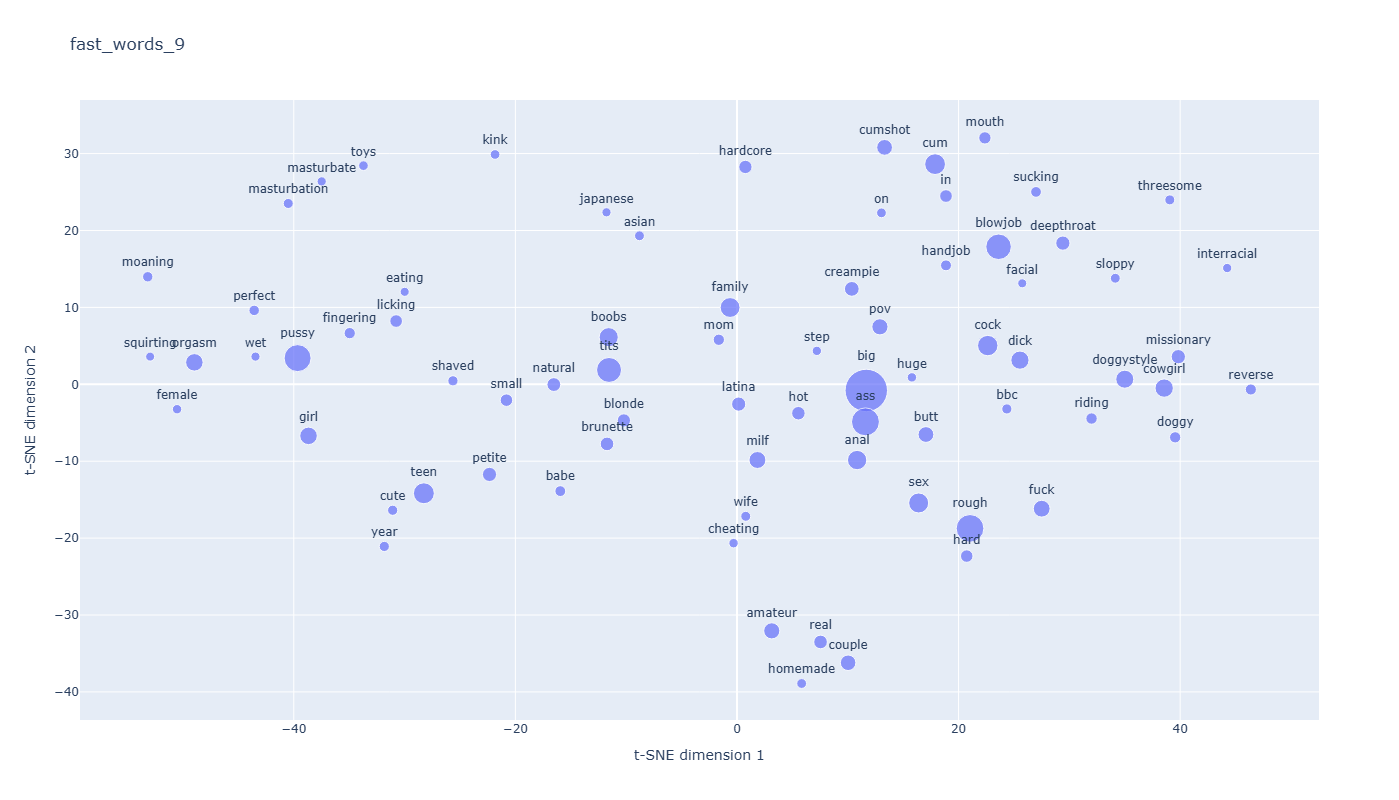

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



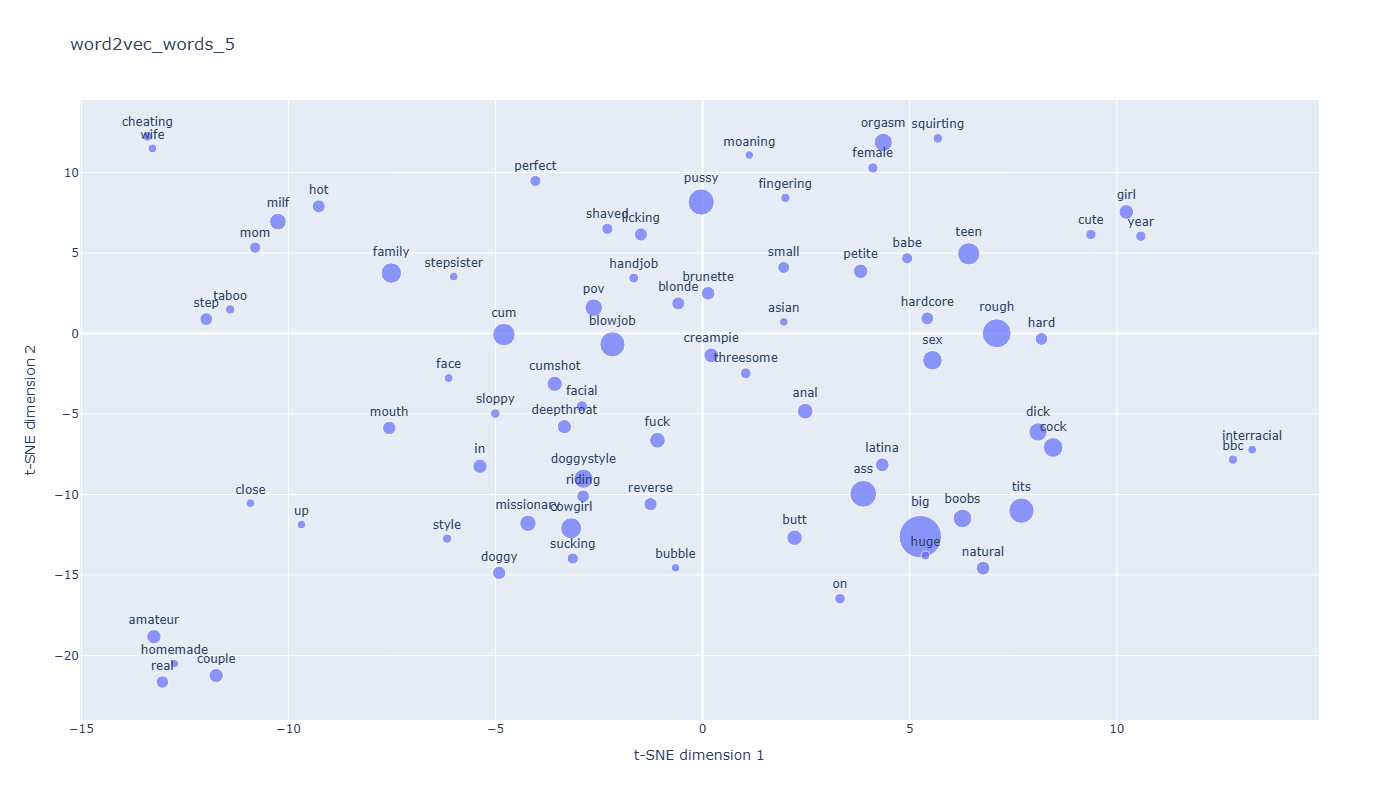

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



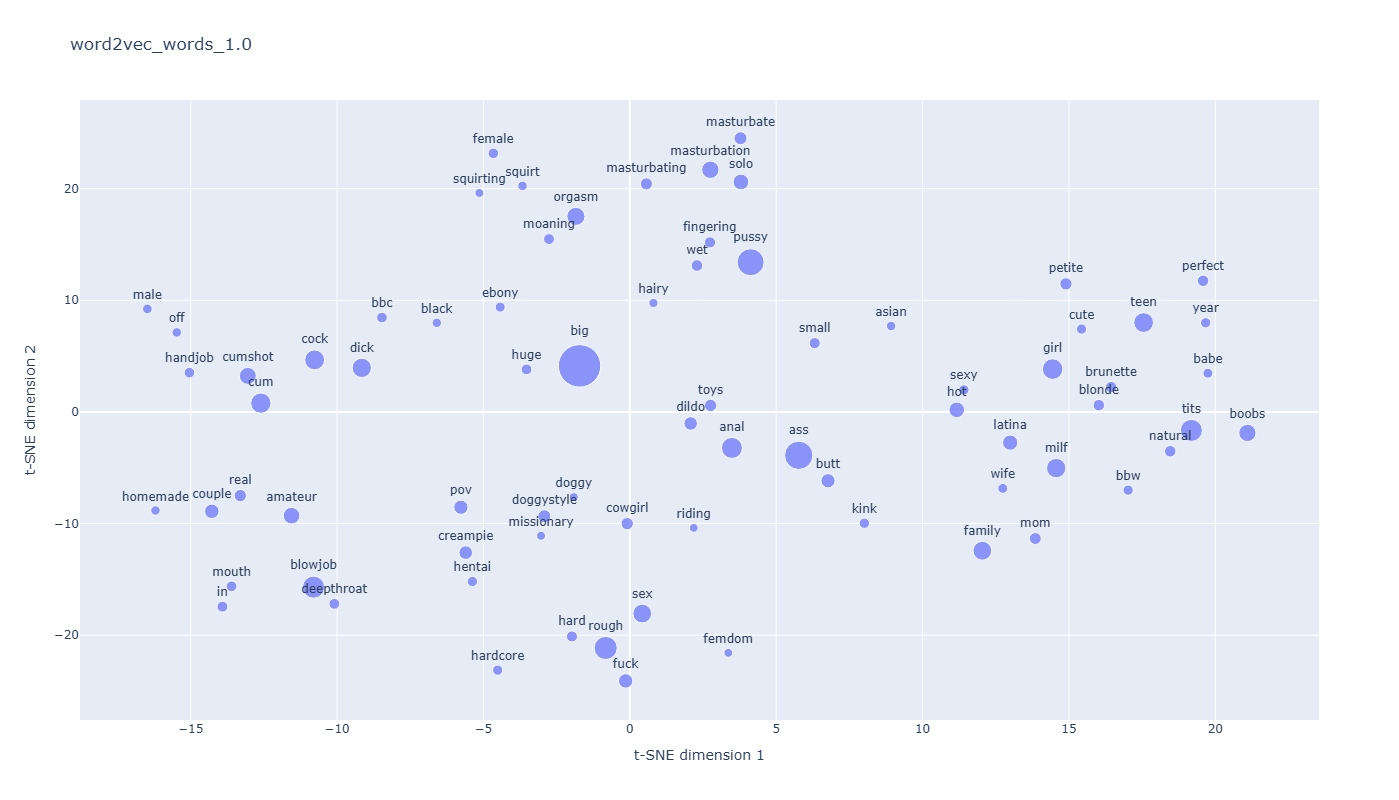

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



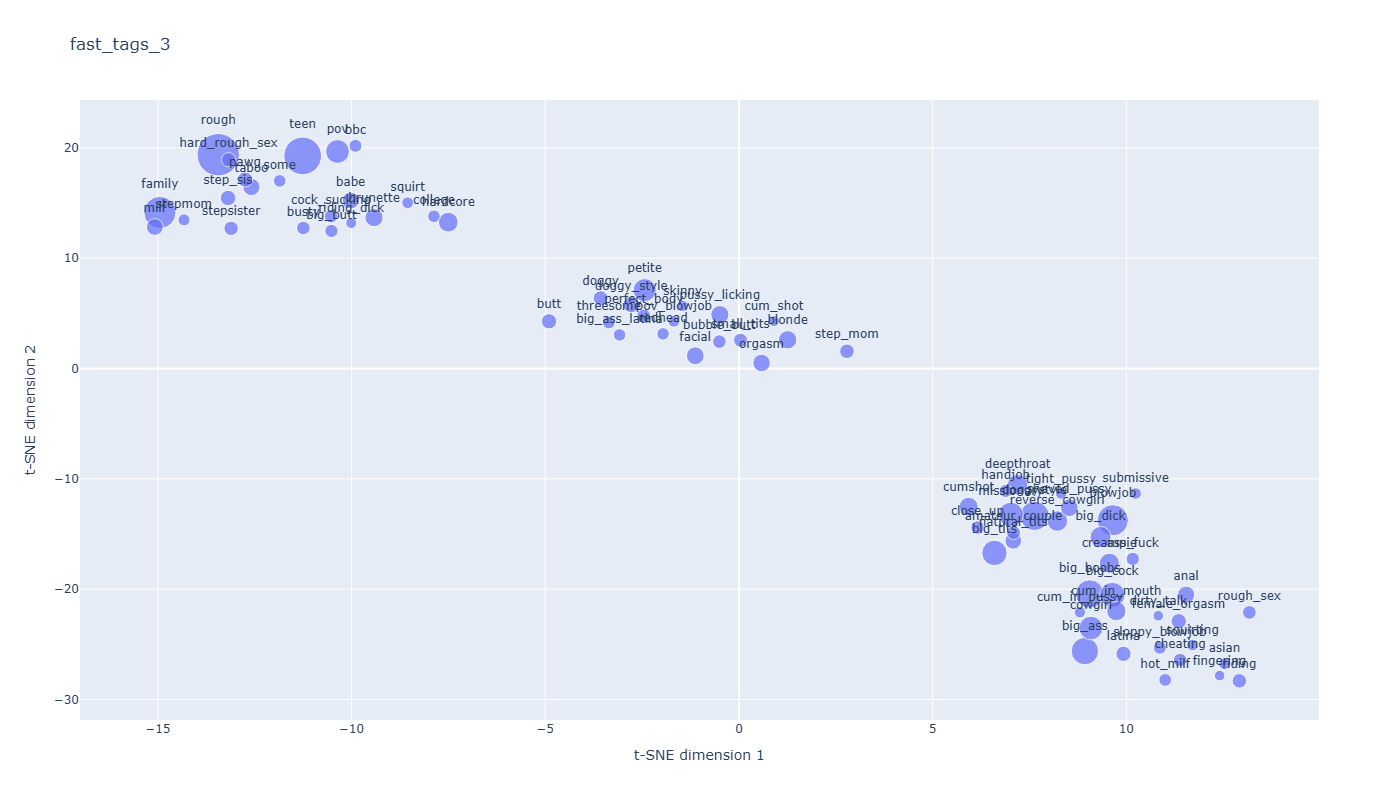

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



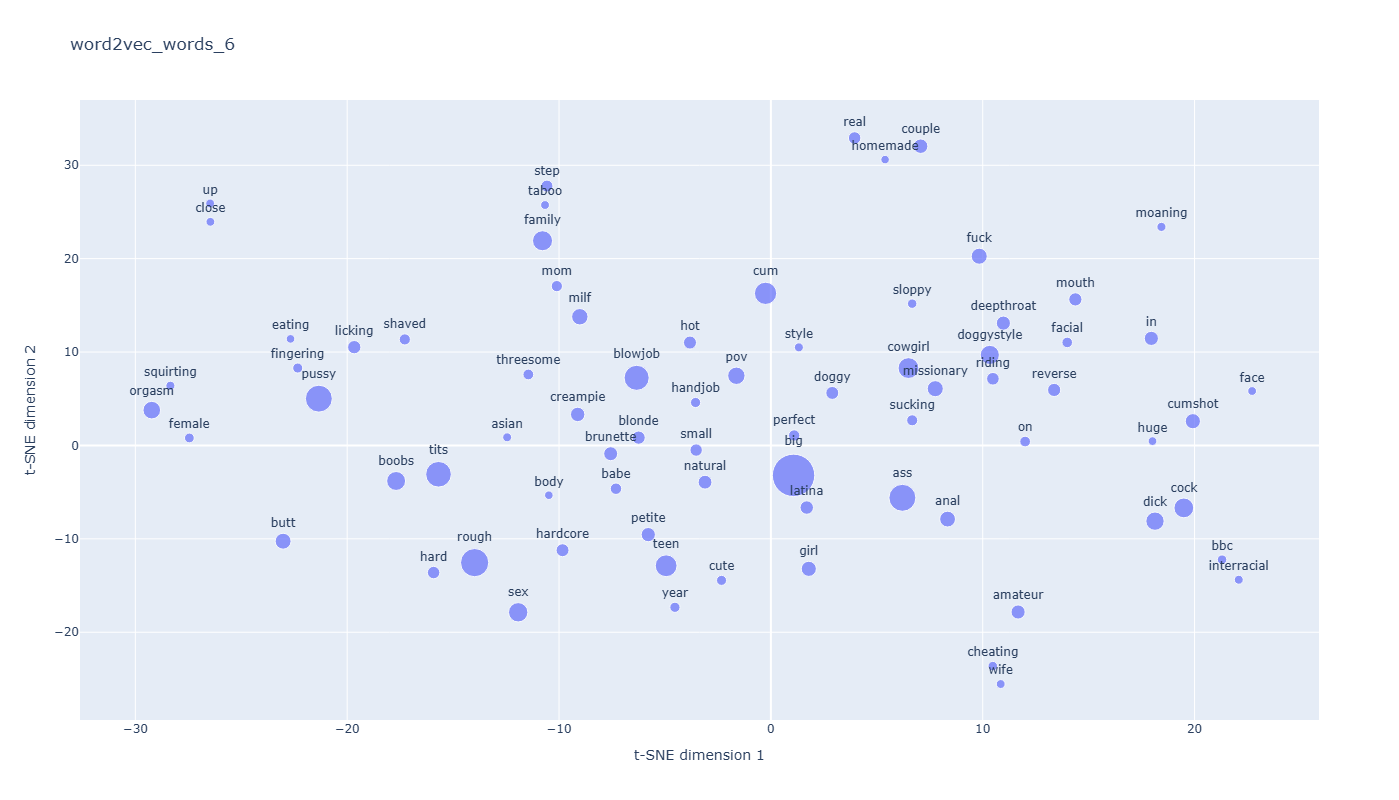

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



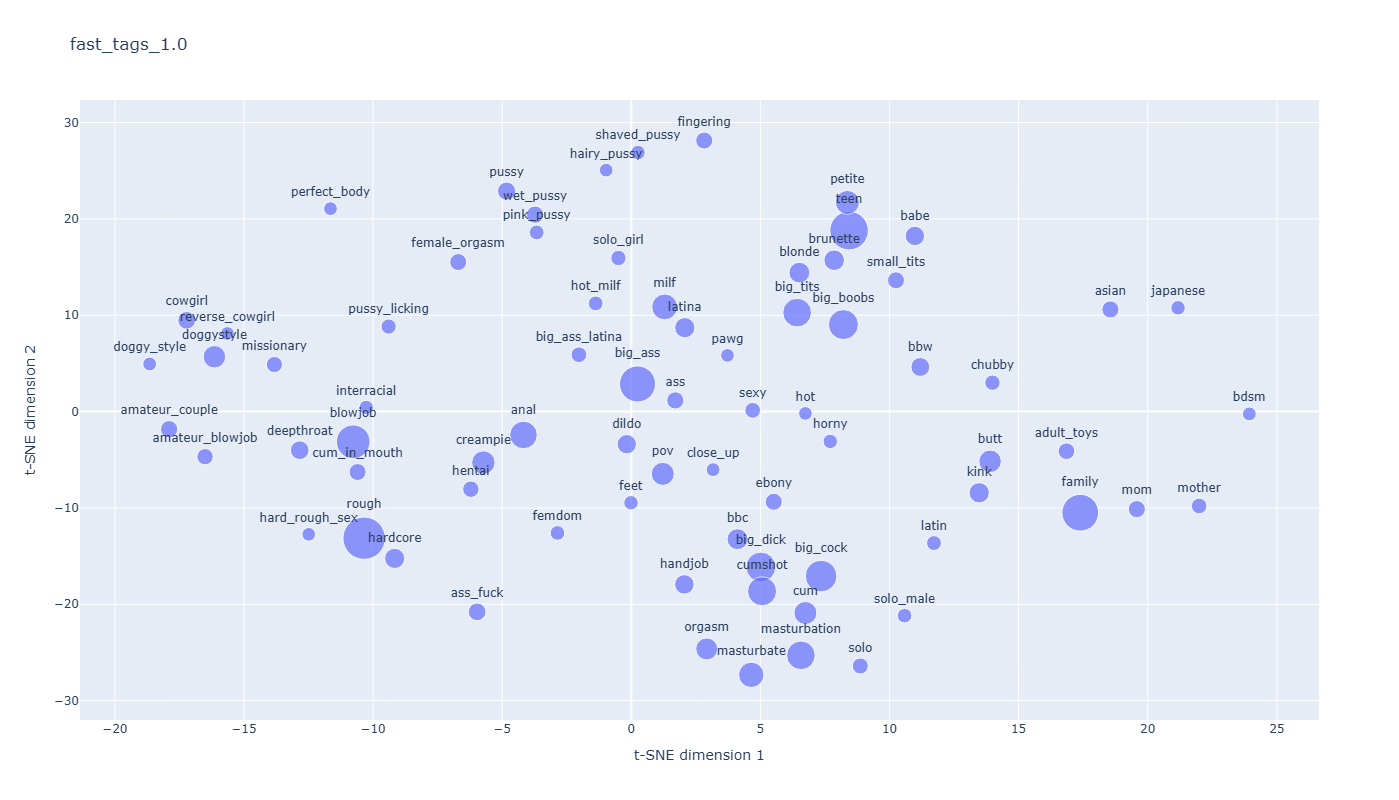

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



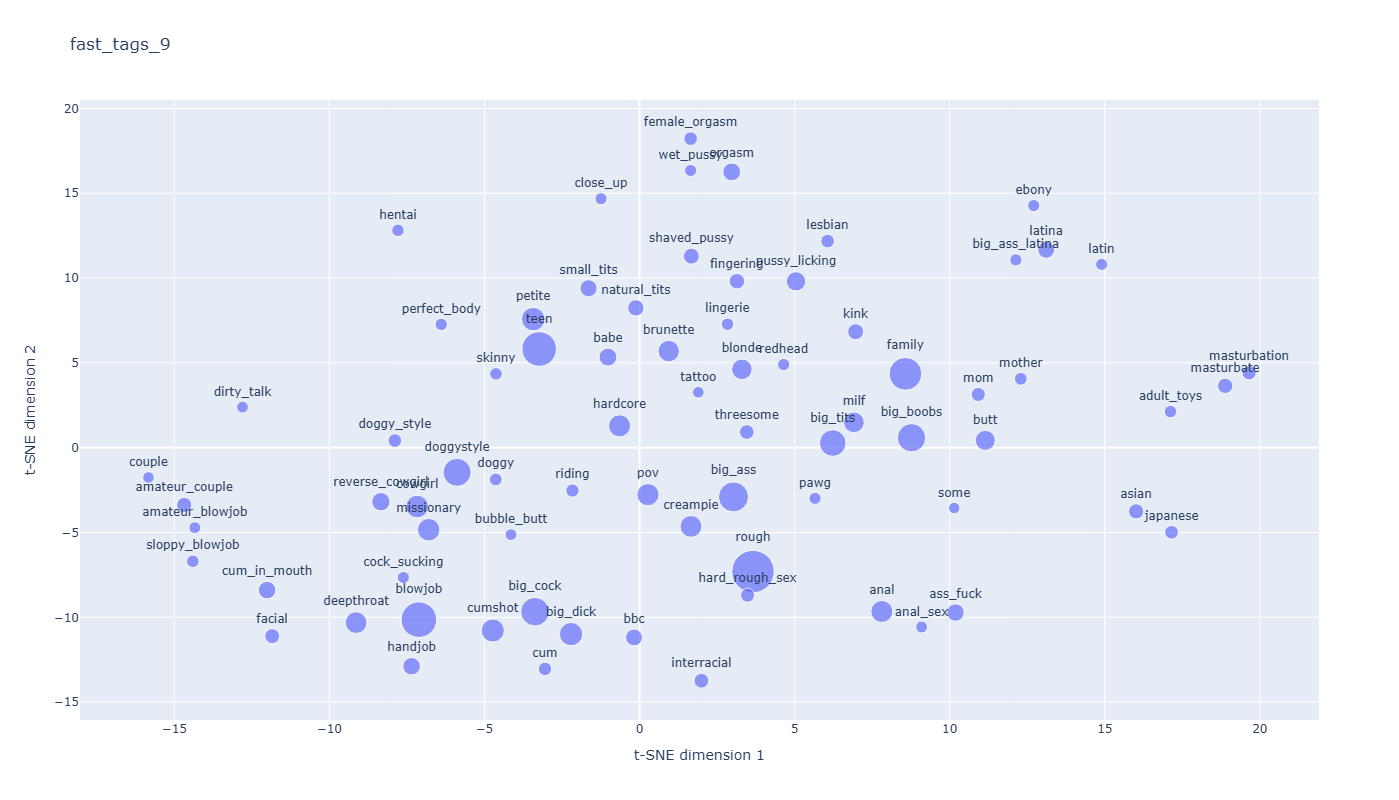

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



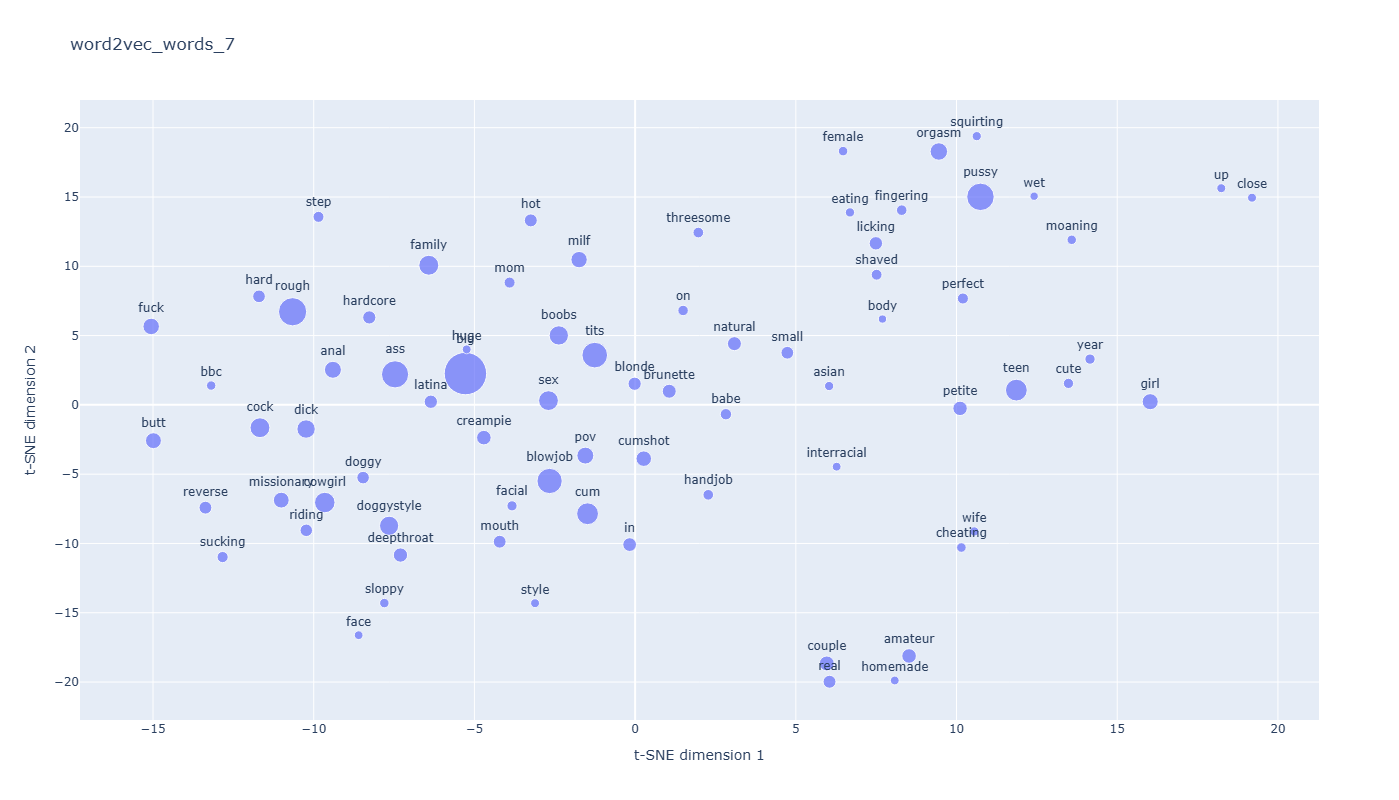

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



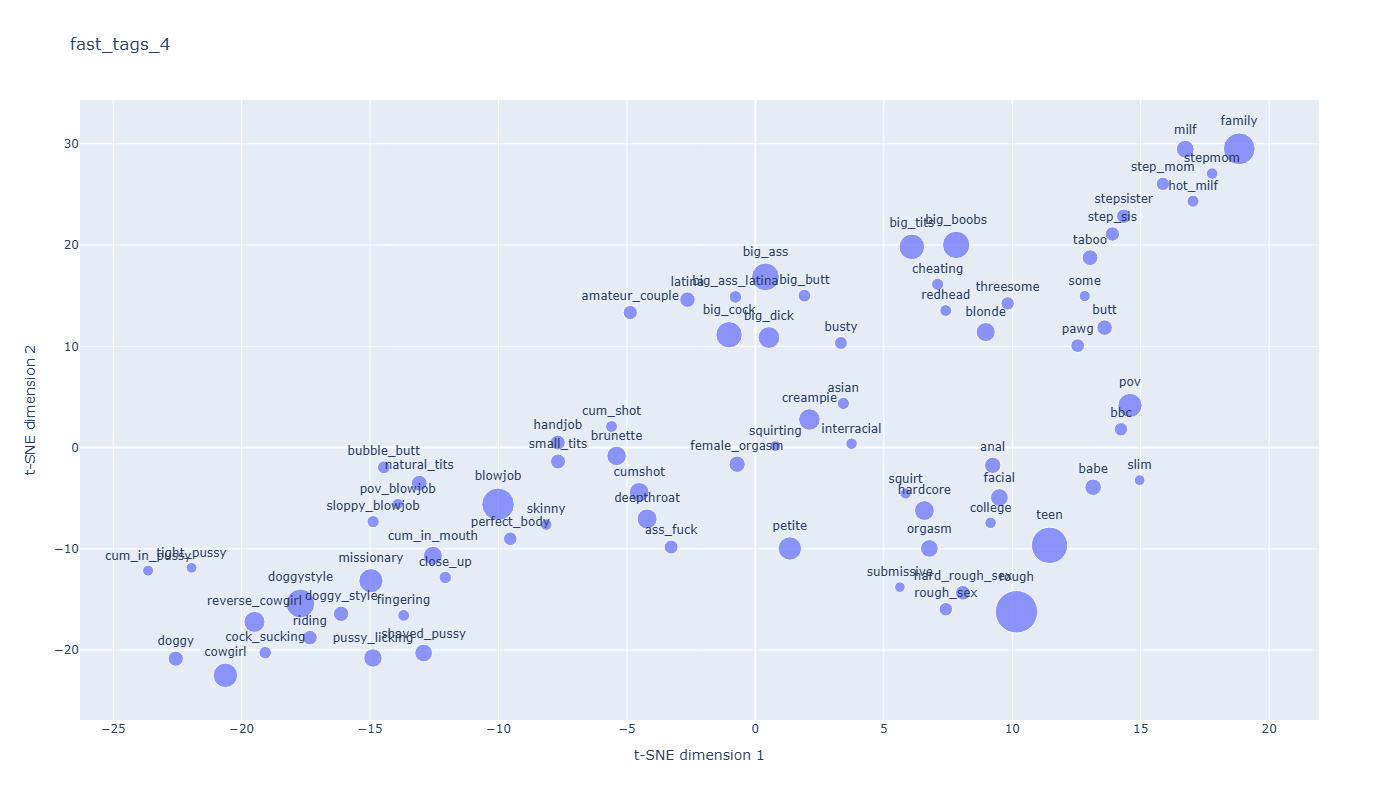

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



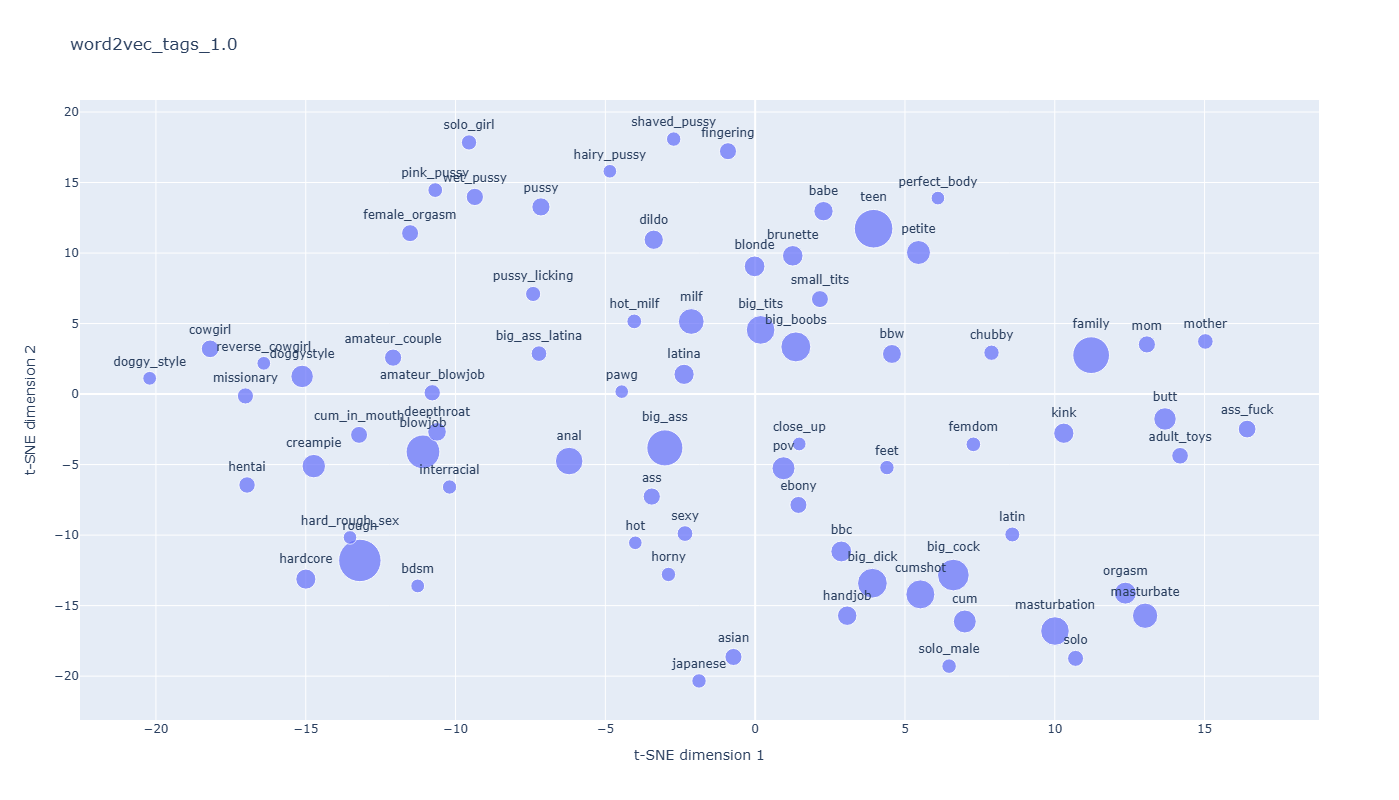

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



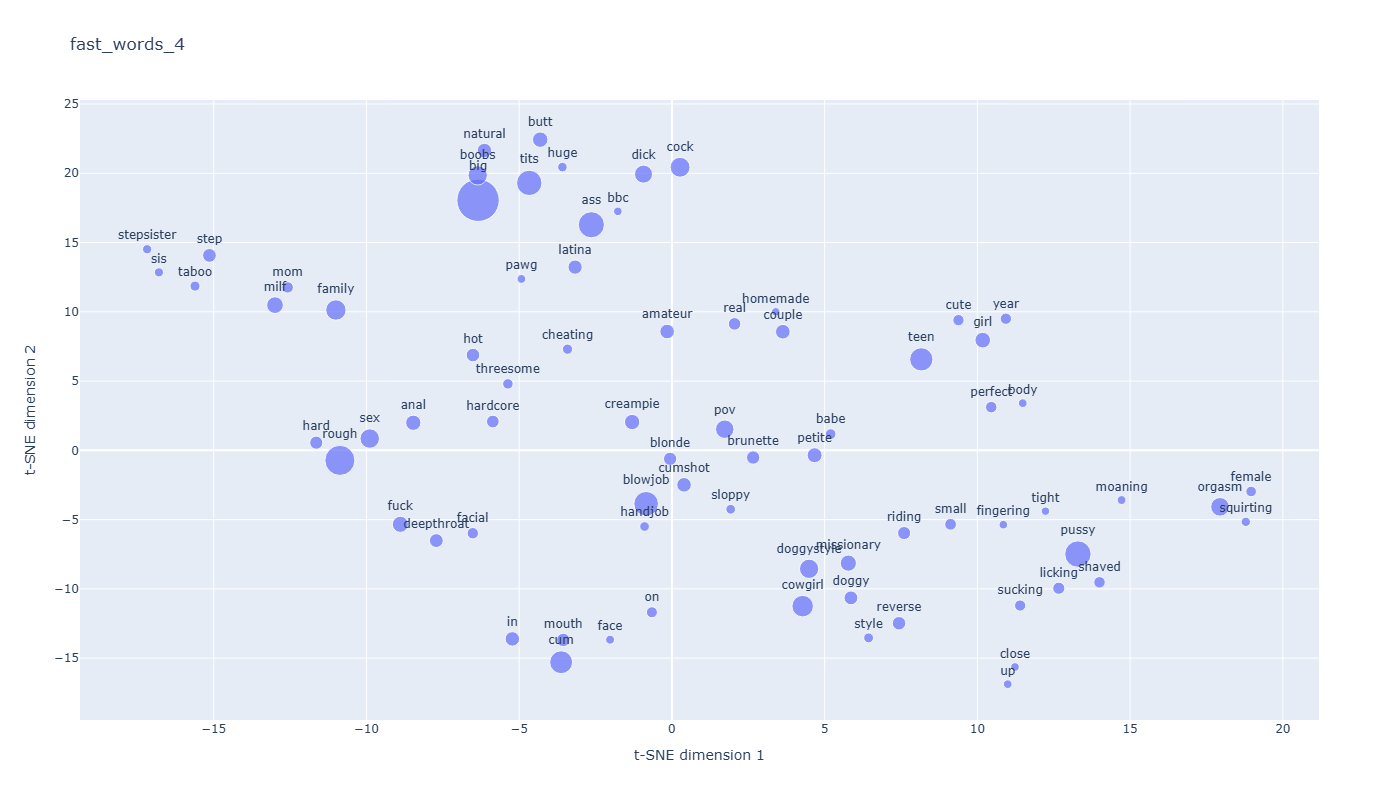

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



In [12]:
for k in trained_embeddings:
    fig = plot_word_map(trained_embeddings[k], num_words=75, perplexity=10, title = k)
    fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



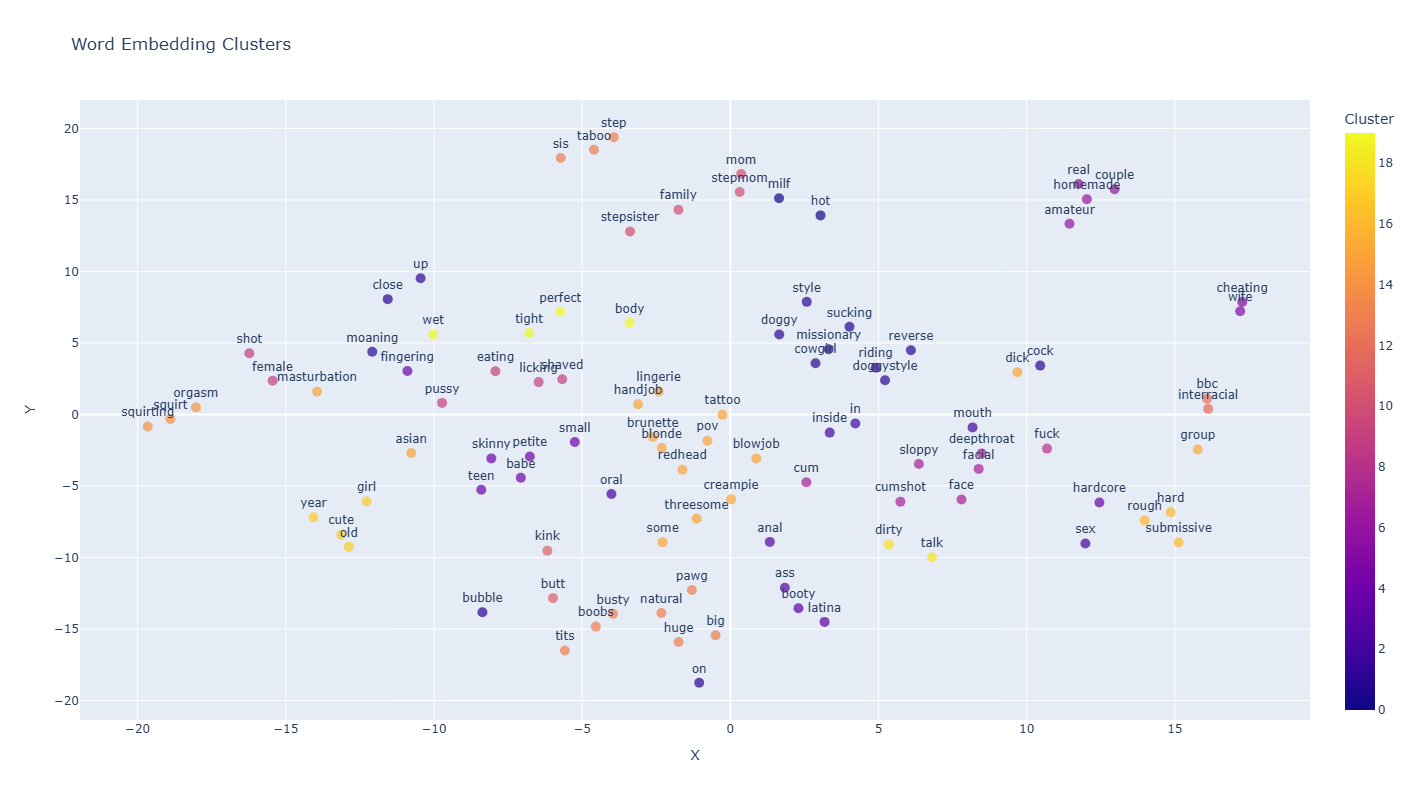

In [15]:
# Word clusters
for k in list(trained_embeddings.keys())[6:7]:
    fig_clusters = plot_word_clusters(trained_embeddings[k], num_words=100, n_clusters=20, perplexity=10)
    fig_clusters.show()

In [58]:
k

'word2vec_words_5'

Applying t-SNE with perplexity=10...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



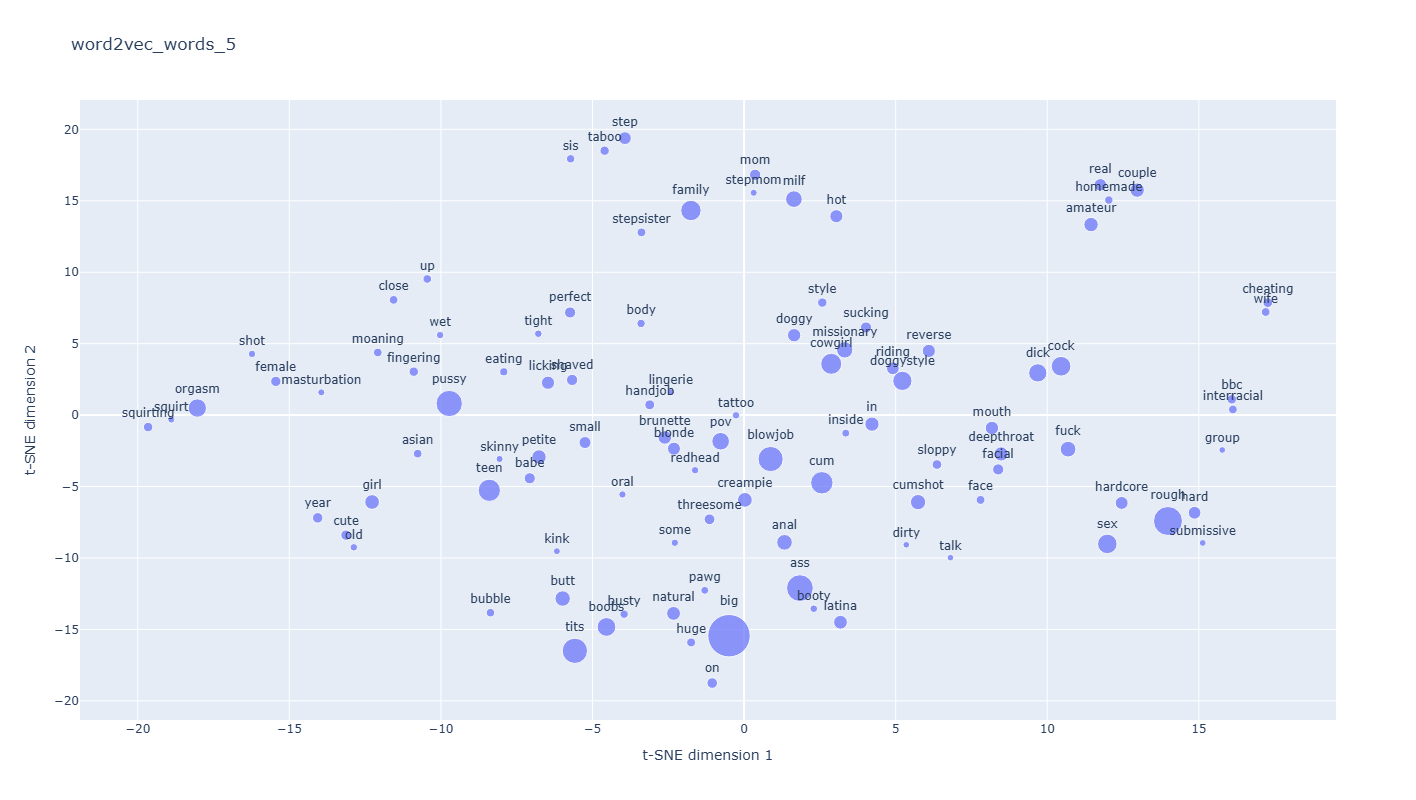

In [16]:
fig = plot_word_map(trained_embeddings[k], num_words=100, perplexity=10, title = k)
fig.show()

In [28]:
paths

['Trained_embeddings/fast_tags_0.8.model',
 'Trained_embeddings/word2vec_words_0.8.model',
 'Trained_embeddings/word2vec_tags_0.6.model',
 'Trained_embeddings/fast_tags_0.2.model',
 'Trained_embeddings/word2vec_tags_0.9.model',
 'Trained_embeddings/fast_words_0.9.model',
 'Trained_embeddings/word2vec_words_0.5.model',
 'Trained_embeddings/word2vec_words_1.0.model',
 'Trained_embeddings/fast_tags_0.3.model',
 'Trained_embeddings/word2vec_words_0.6.model',
 'Trained_embeddings/fast_tags_1.0.model',
 'Trained_embeddings/fast_tags_0.9.model',
 'Trained_embeddings/word2vec_words_0.7.model',
 'Trained_embeddings/fast_tags_0.4.model',
 'Trained_embeddings/word2vec_tags_1.0.model',
 'Trained_embeddings/fast_words_0.4.model',
 'Trained_embeddings/fast_words_0.7.model',
 'Trained_embeddings/word2vec_tags_0.2.model',
 'Trained_embeddings/word2vec_words_0.2.model',
 'Trained_embeddings/word2vec_tags_0.7.model',
 'Trained_embeddings/fast_words_1.0.model',
 'Trained_embeddings/word2vec_tags_0.3.mode

In [ ]:
word2vec_words_5